In [2]:
from tensorflow.keras.models import load_model


cnn_model =load_model("/content/drive/MyDrive/airplane_cnn_model.keras")
print("✅ Model loaded successfully from Drive!")


✅ Model loaded successfully from Drive!


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
!unzip -q "/content/drive/MyDrive/NTI/Images.zip" -d "/content/Images"


In [4]:
test_folder = "/content/Images/Images"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model loaded!


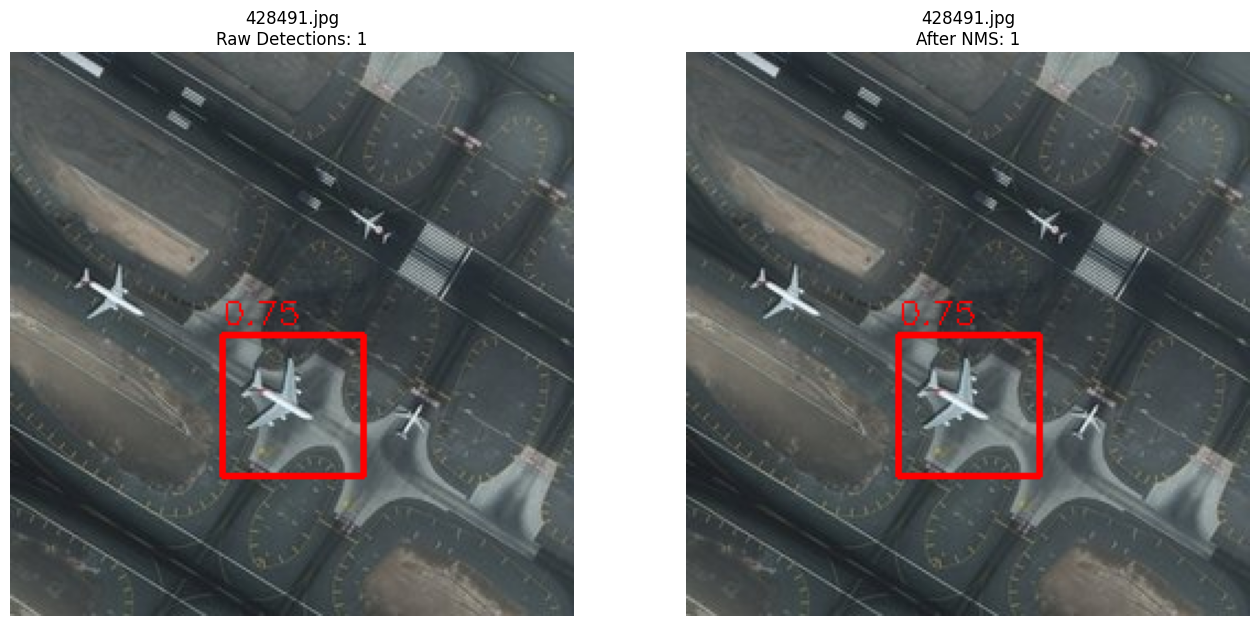

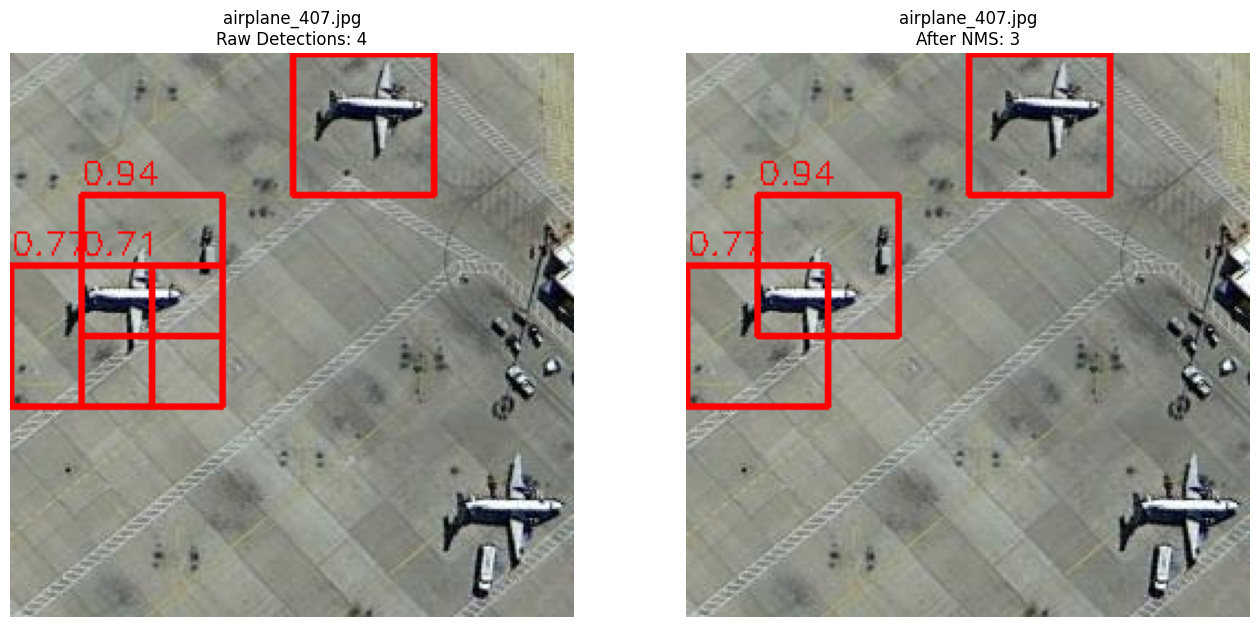

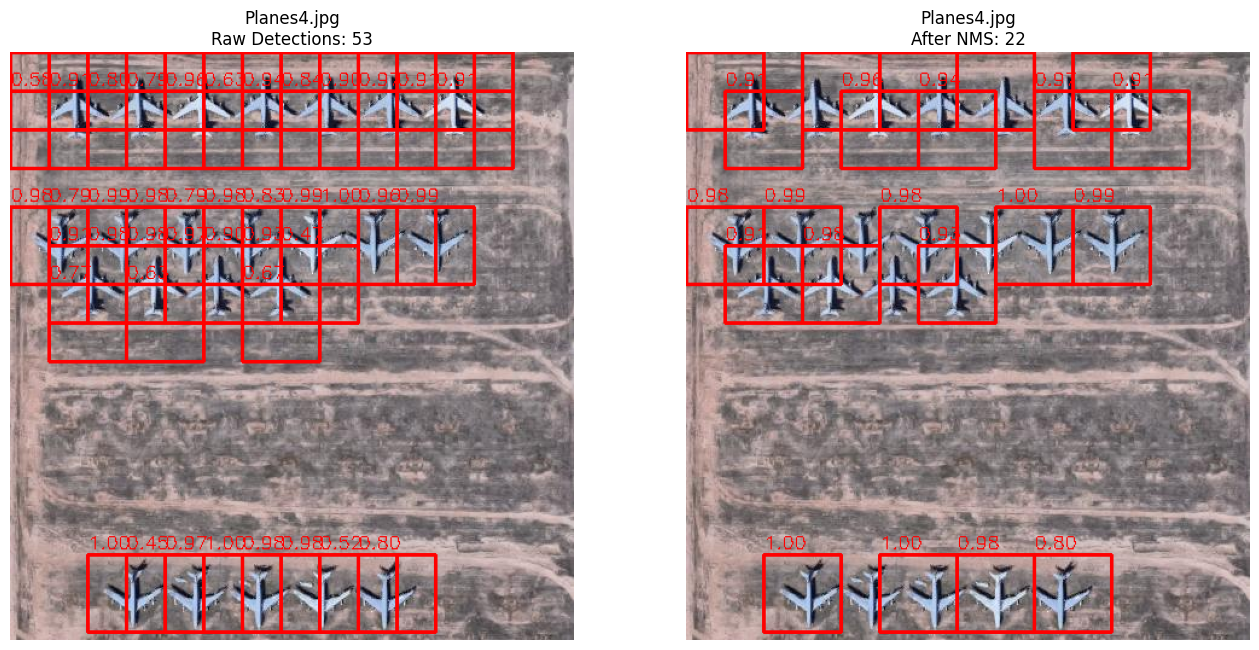

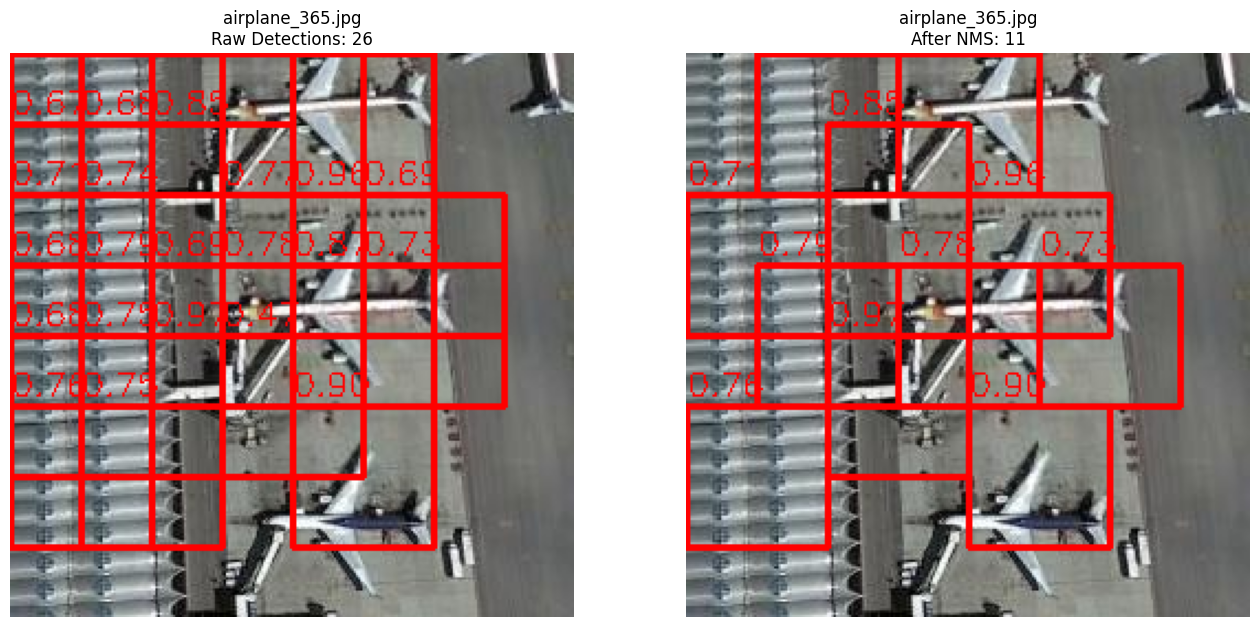

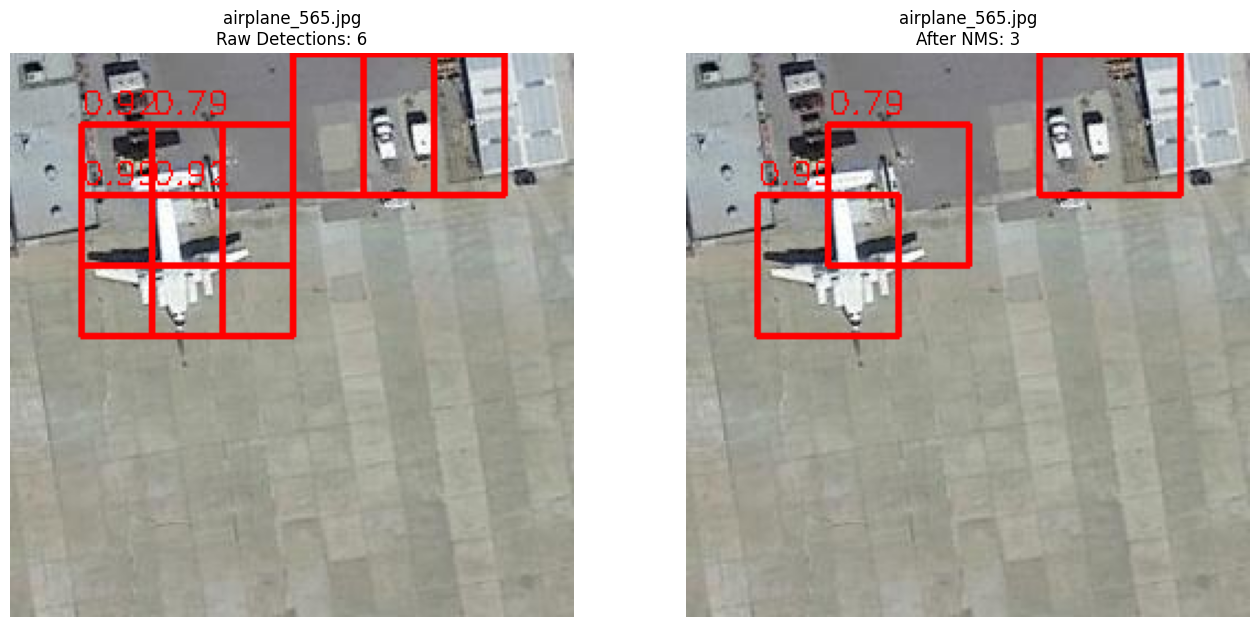

In [5]:
# ==============================
# 1️⃣ Mount Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

# ==============================
# 2️⃣ Load the trained model
# ==============================
from tensorflow.keras.models import load_model


cnn_model = load_model("/content/drive/MyDrive/NTI/airplane_detector.h5")
print("✅ Model loaded!")

# ==============================
# 3️⃣ Define helper functions
# ==============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Sliding window
def sliding_window(img, step=32, window_size=(64,64)):
    for y in range(0, img.shape[0]-window_size[1], step):
        for x in range(0, img.shape[1]-window_size[0], step):
            yield (x, y, img[y:y+window_size[1], x:x+window_size[0]])

# Detect airplanes
def detect_airplanes(img_path, model, conf_thresh=0.4):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = []
    for (x, y, window) in sliding_window(img, step=32, window_size=(64,64)):
        if window.shape[0] != 64 or window.shape[1] != 64:
            continue
        win_norm = window.astype("float32") / 255.0
        win_norm = np.expand_dims(win_norm, axis=0)
        pred = model.predict(win_norm, verbose=0)[0][0]
        if pred > conf_thresh:
            detections.append((x, y, x+64, y+64, pred))
    return img_rgb, detections

# Non-Max Suppression
def non_max_suppression(detections, iou_thresh=0.3):
    if len(detections) == 0:
        return []
    boxes = np.array(detections)
    x1, y1, x2, y2, scores = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3], boxes[:,4]
    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        area_i = (x2[i] - x1[i]) * (y2[i] - y1[i])
        area_others = (x2[idxs[1:]] - x1[idxs[1:]]) * (y2[idxs[1:]] - y1[idxs[1:]])
        iou = inter / (area_i + area_others - inter + 1e-6)
        idxs = idxs[1:][iou < iou_thresh]
    return boxes[keep].tolist()

# Draw boxes
def draw_boxes(img_rgb, detections):
    img_vis = img_rgb.copy()
    for (x1, y1, x2, y2, conf) in detections:
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img_vis, f"{conf:.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    return img_vis

# Compare detections before/after NMS
def compare_detections(img_rgb, detections, final_detections, img_name, save_dir=None):
    raw_img = draw_boxes(img_rgb, detections)
    nms_img = draw_boxes(img_rgb, final_detections)

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(raw_img)
    plt.title(f"{img_name}\nRaw Detections: {len(detections)}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(nms_img)
    plt.title(f"{img_name}\nAfter NMS: {len(final_detections)}")
    plt.axis("off")

    plt.show()


    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        cv2.imwrite(os.path.join(save_dir, f"{img_name}_raw.jpg"), cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(save_dir, f"{img_name}_nms.jpg"), cv2.cvtColor(nms_img, cv2.COLOR_RGB2BGR))

# ==============================
# 4️⃣ Batch Testing
# ==============================
def batch_detect(folder_path, model, conf_thresh=0.4, iou_thresh=0.2, limit=5, save_dir=None):
    images = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    for idx, img_name in enumerate(images[:limit]):  # limit=5 → أول 5 صور
        img_path = os.path.join(folder_path, img_name)
        img_rgb, detections = detect_airplanes(img_path, model, conf_thresh=conf_thresh)
        final_detections = non_max_suppression(detections, iou_thresh=iou_thresh)
        compare_detections(img_rgb, detections, final_detections, img_name, save_dir=save_dir)

# ==============================
# 5️⃣ Run Example
# ==============================
test_folder = "/content/Images/Images"
output_folder = "/content/detection_results"

batch_detect(test_folder, cnn_model, conf_thresh=0.4, iou_thresh=0.2, limit=5, save_dir=output_folder)




✅ Model loaded!


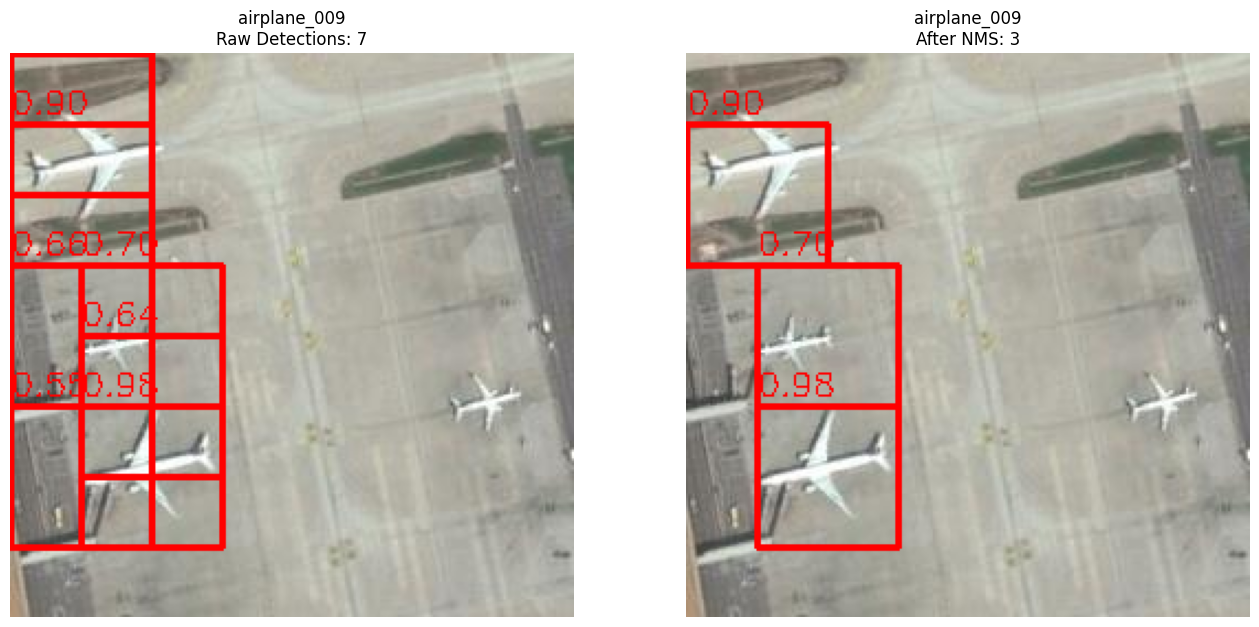

✅ Single image: 3 airplanes detected


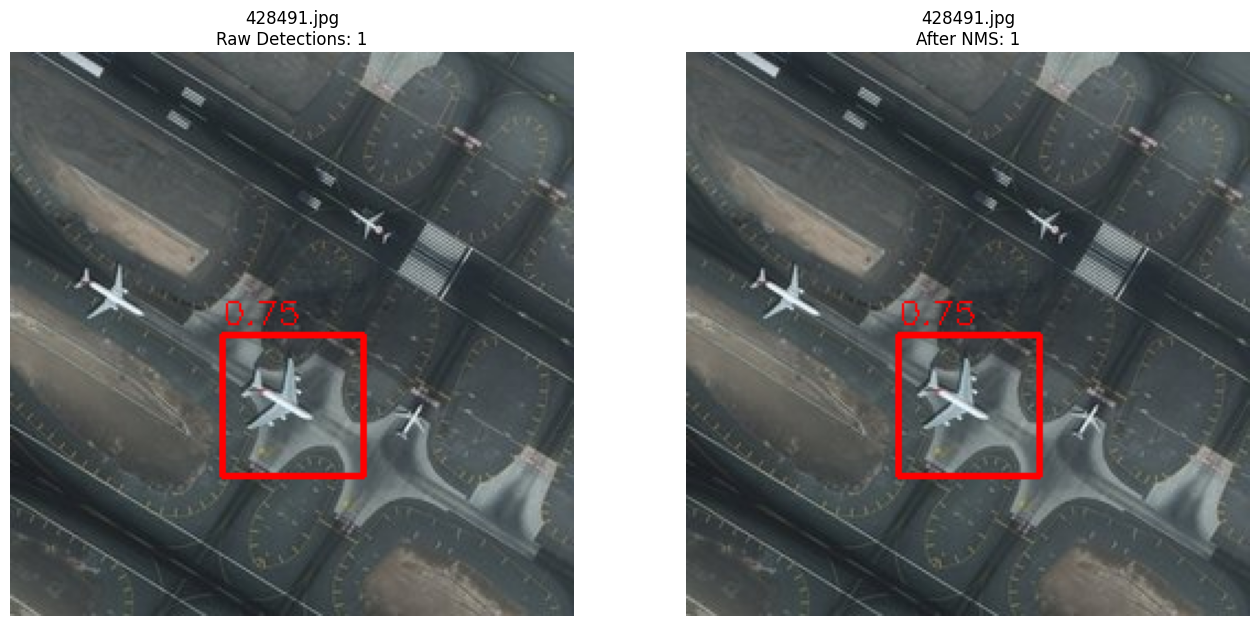

✅ 428491.jpg: 1 airplanes detected after NMS


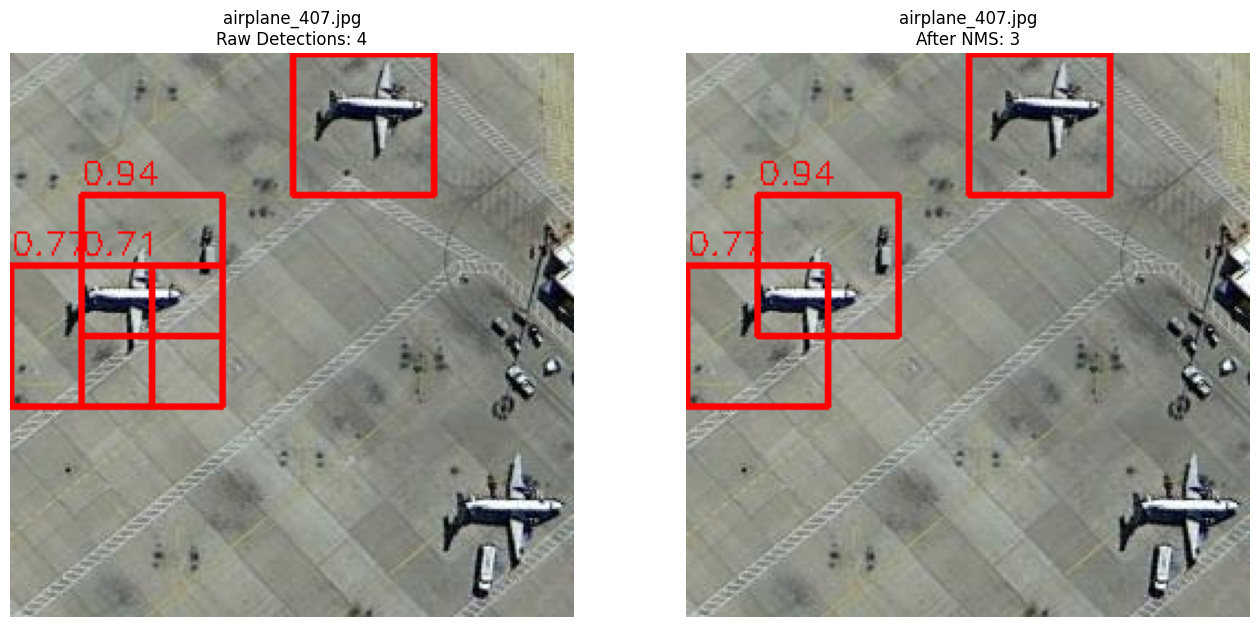

✅ airplane_407.jpg: 3 airplanes detected after NMS


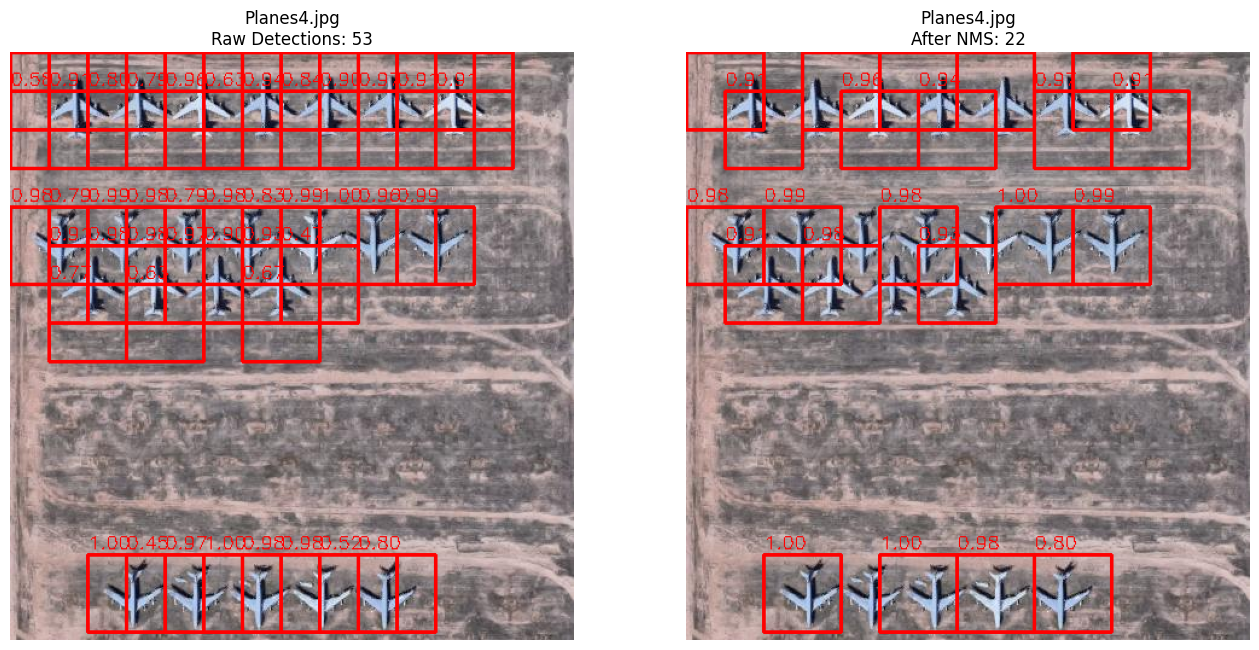

✅ Planes4.jpg: 22 airplanes detected after NMS


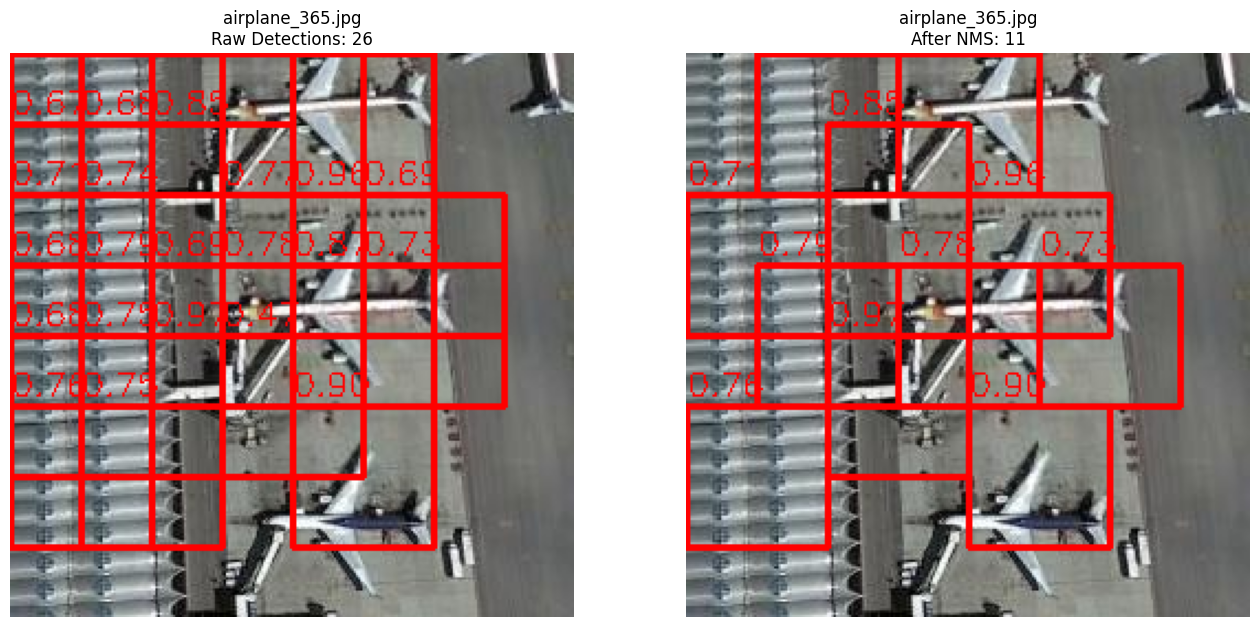

✅ airplane_365.jpg: 11 airplanes detected after NMS


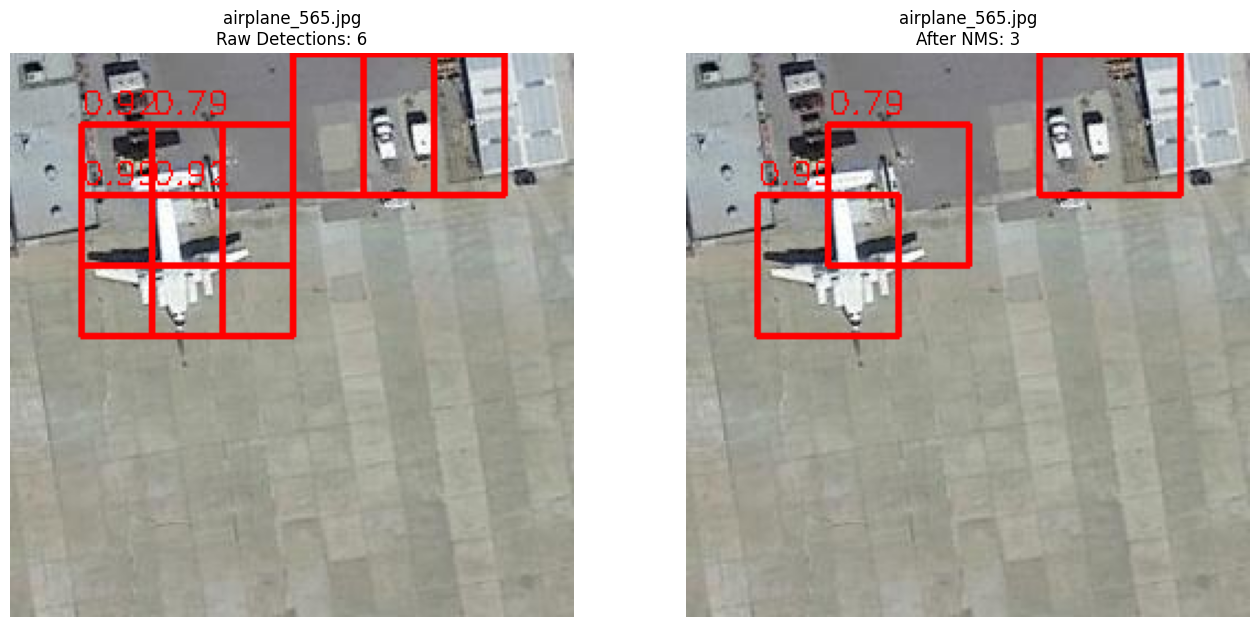

✅ airplane_565.jpg: 3 airplanes detected after NMS


In [6]:


# ==============================
# 2️⃣ Load the trained model
# ==============================
from tensorflow.keras.models import load_model

# ✨ Change the path if saved elsewhere
cnn_model = load_model("/content/drive/MyDrive/NTI/airplane_detector.h5")
print("✅ Model loaded!")

# ==============================
# 3️⃣ Define helper functions
# ==============================
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Sliding window generator
def sliding_window(img, step=32, window_size=(64,64)):
    for y in range(0, img.shape[0]-window_size[1], step):
        for x in range(0, img.shape[1]-window_size[0], step):
            yield (x, y, img[y:y+window_size[1], x:x+window_size[0]])

# Detect airplanes using CNN model + sliding window
def detect_airplanes(img_path, model, conf_thresh=0.4):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = []
    for (x, y, window) in sliding_window(img, step=32, window_size=(64,64)):
        if window.shape[0] != 64 or window.shape[1] != 64:
            continue
        win_norm = window.astype("float32") / 255.0
        win_norm = np.expand_dims(win_norm, axis=0)
        pred = model.predict(win_norm, verbose=0)[0][0]
        if pred > conf_thresh:
            detections.append((x, y, x+64, y+64, pred))
    return img_rgb, detections

# Non-Max Suppression (remove duplicate overlapping boxes)
def non_max_suppression(detections, iou_thresh=0.3):
    if len(detections) == 0:
        return []
    boxes = np.array(detections)
    x1, y1, x2, y2, scores = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3], boxes[:,4]
    idxs = np.argsort(scores)[::-1]
    keep = []
    while len(idxs) > 0:
        i = idxs[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[1:]])
        yy1 = np.maximum(y1[i], y1[idxs[1:]])
        xx2 = np.minimum(x2[i], x2[idxs[1:]])
        yy2 = np.minimum(y2[i], y2[idxs[1:]])
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)
        inter = w * h
        area_i = (x2[i] - x1[i]) * (y2[i] - y1[i])
        area_others = (x2[idxs[1:]] - x1[idxs[1:]]) * (y2[idxs[1:]] - y1[idxs[1:]])
        iou = inter / (area_i + area_others - inter + 1e-6)
        idxs = idxs[1:][iou < iou_thresh]
    return boxes[keep].tolist()

# Draw bounding boxes on image
def draw_boxes(img_rgb, detections):
    img_vis = img_rgb.copy()
    for (x1, y1, x2, y2, conf) in detections:
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(img_vis, f"{conf:.2f}", (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1)
    return img_vis

# Compare detections before/after NMS
def compare_detections(img_rgb, detections, final_detections, img_name, save_dir=None):
    raw_img = draw_boxes(img_rgb, detections)
    nms_img = draw_boxes(img_rgb, final_detections)

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.imshow(raw_img)
    plt.title(f"{img_name}\nRaw Detections: {len(detections)}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(nms_img)
    plt.title(f"{img_name}\nAfter NMS: {len(final_detections)}")
    plt.axis("off")

    plt.show()

    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        cv2.imwrite(os.path.join(save_dir, f"{img_name}_raw.jpg"), cv2.cvtColor(raw_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(save_dir, f"{img_name}_nms.jpg"), cv2.cvtColor(nms_img, cv2.COLOR_RGB2BGR))

# Batch testing on a folder
def batch_detect(folder_path, model, conf_thresh=0.4, iou_thresh=0.2, limit=5, save_dir=None):
    images = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
    for idx, img_name in enumerate(images[:limit]):
        img_path = os.path.join(folder_path, img_name)
        img_rgb, detections = detect_airplanes(img_path, model, conf_thresh=conf_thresh)
        final_detections = non_max_suppression(detections, iou_thresh=iou_thresh)
        compare_detections(img_rgb, detections, final_detections, img_name, save_dir=save_dir)
        print(f"✅ {img_name}: {len(final_detections)} airplanes detected after NMS")

# ==============================
# 4️⃣ Single Image Test
# ==============================
test_img_path = "/content/Images/Images/airplane_009.jpg"  # change to your image
img_name = os.path.basename(test_img_path).replace(".jpg", "")

# Run detection
img_rgb, detections = detect_airplanes(test_img_path, cnn_model, conf_thresh=0.4)
final_detections = non_max_suppression(detections, iou_thresh=0.2)

# Compare results
compare_detections(img_rgb, detections, final_detections, img_name, save_dir="/content/detection_results")
print(f"✅ Single image: {len(final_detections)} airplanes detected")

# ==============================
# 5️⃣ Batch Example
# ==============================
test_folder = "/content/Images/Images"  # change this to your folder
output_folder = "/content/detection_results"

batch_detect(test_folder, cnn_model, conf_thresh=0.4, iou_thresh=0.2, limit=5, save_dir=output_folder)


In [9]:
!pip install gradio

import gradio as gr
from tensorflow.keras.models import load_model
import cv2, numpy as np

# Load model
model = load_model("/content/drive/MyDrive/airplane_cnn_model.keras")

# Define inference function
def predict_airplane(image):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    img_rgb, detections = detect_airplanes("/content/tmp.jpg", model, conf_thresh=0.4)
    final_detections = non_max_suppression(detections, iou_thresh=0.2)
    output = draw_boxes(img_rgb, final_detections)
    return cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Build interface
demo = gr.Interface(
    fn=predict_airplane,
    inputs=gr.Image(type="numpy", label="Upload Aerial Image"),
    outputs=gr.Image(type="numpy", label="Detected Airplanes"),
    title="✈️ Airplane Detection CNN",
    description="Upload an image and detect airplanes using a trained CNN model."
)

demo.launch()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1872ac18edb9f465dd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
